In [6]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

In [3]:
import torch
from torch.utils.data import DataLoader

In [4]:
%load_ext autoreload
%autoreload 2
from ddpm_tutorial.dataset_toyzero import Toyzero
from ddpm_tutorial.ddpm import DDPM
from ddpm_tutorial.unet import Unet
from ddpm_translate import DDPMTranslate

ModuleNotFoundError: No module named 'einops'

In [ ]:
CKPT_DIR = Path("./checkpoints/")
IMG_DIR = Path("./images/toyzero_normalized_translation/")

In [5]:
epoch = 99
encoder_ckpt = CKPT_DIR/f'toyzero_normalized-100_fake/epc_{epoch}.pt'
decoder_ckpt = CKPT_DIR/f'toyzero_normalized-100_real/epc_{epoch}.pt'

NameError: name 'CKPT_DIR' is not defined

In [6]:
TOYZERO_DIR = Path('/data/datasets/LS4GAN/toy-adc_256x256_precropped')
batch_size = 4
data_fake = Toyzero(TOYZERO_DIR, partition='test', domain='fake', shuffle=False)
data_real = Toyzero(TOYZERO_DIR, partition='test', domain='real', shuffle=False)
dlr_fake = DataLoader(data_fake, batch_size, num_workers=8)
dlr_real = DataLoader(data_real, batch_size, num_workers=8)

In [42]:
def plot(fake, tran, real, height=2.5, width=2.5, scale=1, titles=None):
    diff = real - tran
    l1 = np.abs(real - tran).mean()
    if titles is None:
        titles = ['fake', 'tran', 'real', f'L_1={l1:.5f}']
    else:
        titles += [f'L_1={l1:.5f}'] 
    images = [fake, tran, real, diff]
    vrange = max(max(np.abs(image.min()), np.abs(image.max())) for image in images)
    
    fig, axes = plt.subplots(1, 4, figsize=(width * 4, height))
    
    for image, ax, title in zip(images, axes, titles):    
        
        norm = matplotlib.colors.SymLogNorm(linthresh=0.01 * scale, vmin=-vrange, vmax=vrange)
        ax.axis('off')
        ax.set_title(title)
        img = image * scale
        # img[np.abs(img) < 0.01]=0
        im = ax.imshow(img, cmap='seismic', norm=norm)
    
    cax = ax.inset_axes([1.1, 0.0, 0.08, 1], transform=ax.transAxes)
    fig.colorbar(im, ax=axes, cax=cax)
    plt.tight_layout()
        
    return fig

In [8]:
iter_fake = iter(dlr_fake)
iter_real = iter(dlr_real)

fake, fake_fname = next(iter_fake)
real, real_fname = next(iter_real)

In [1]:
steps = 200
translator = DDPMTranslate(encoder_ckpt, decoder_ckpt, encode_step=steps, decode_step=steps)
tran = translator.translate(fake.cuda(), record_freq=20)


NameError: name 'DDPMTranslate' is not defined

fake: -0.31000, 0.36000
tran: -0.31666, 0.42328
real: -0.30000, 0.41000

fake: -0.31000, 0.36000
tran: -0.31003, 0.43303
real: -0.30000, 0.42000

fake: -0.60000, 0.66000
tran: -0.57966, 0.66001
real: -0.60000, 0.77000

fake: -0.34000, 0.39000
tran: -0.34459, 0.45973
real: -0.33000, 0.44000



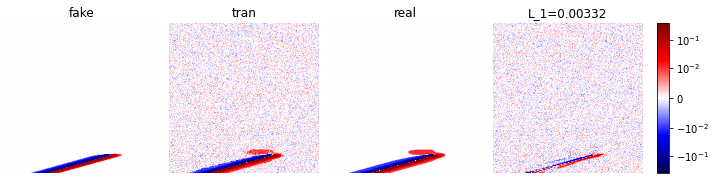

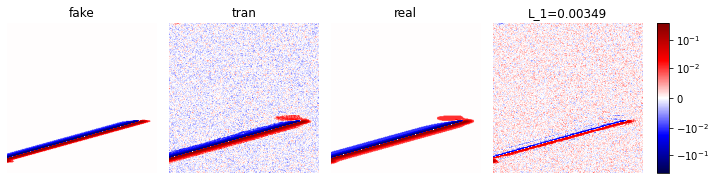

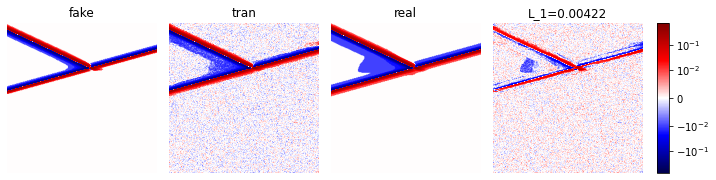

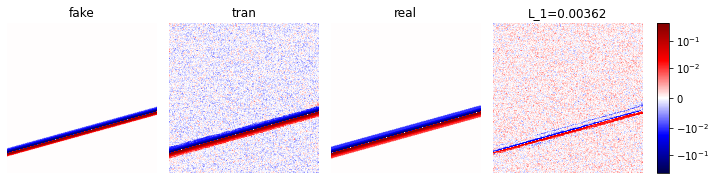

In [39]:
scale = 1
for idx in range(batch_size):
    f_raw = fake[idx].squeeze().numpy()
    f = tran[idx]['input']
    t = tran[idx][0]
    r = real[idx].squeeze().numpy()
    fig = plot(f_raw, t, r, scale=scale)
    fig.savefig(IMG_DIR/f'sample_fake-to-real_{idx}_{steps}.png', bbox_inches='tight', transparent=True, dpi=200)
    print(f'fake: {f_raw.min():.5f}, {f_raw.max():.5f}')
    print(f'tran: {t.min():.5f}, {t.max():.5f}')
    print(f'real: {r.min():.5f}, {r.max():.5f}\n')

100%|██████████| 20/20 [00:02<00:00,  8.84it/s]


fake: -0.34000, 0.39000
tran: -0.37142, 0.43094
real: -0.30000, 0.41000

fake: -0.34000, 0.39000
tran: -0.36871, 0.45373
real: -0.30000, 0.42000

fake: -0.34000, 0.39000
tran: -0.62831, 0.78822
real: -0.60000, 0.77000

fake: -0.34000, 0.39000
tran: -0.38904, 0.45386
real: -0.33000, 0.44000



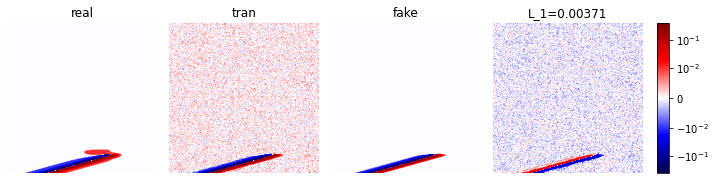

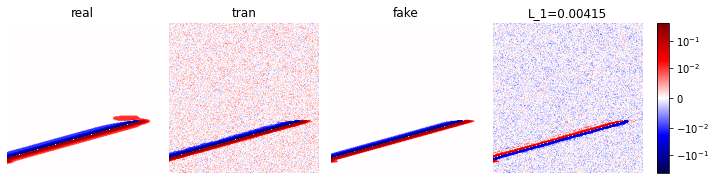

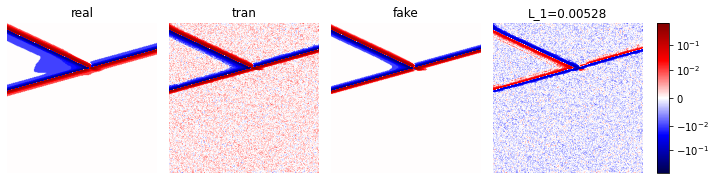

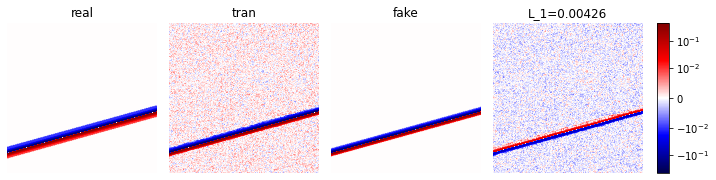

In [47]:
steps = 20
translator = DDPMTranslate(decoder_ckpt, encoder_ckpt, encode_step=steps, decode_step=steps)
tran = translator.translate(real.cuda(), record_freq=20)

scale = 1
for idx in range(batch_size):
    r_raw = real[idx].squeeze().numpy()
    r = tran[idx]['input']
    t = tran[idx][0]
    f = fake[idx].squeeze().numpy()
    fig = plot(r_raw, t, f, scale=scale, titles=['real', 'tran', 'fake'])
    fig.savefig(IMG_DIR/f'sample_real-to-fake_{idx}_{steps}.png', bbox_inches='tight', transparent=True, dpi=200)
    print(f'fake: {f_raw.min():.5f}, {f_raw.max():.5f}')
    print(f'tran: {t.min():.5f}, {t.max():.5f}')
    print(f'real: {r.min():.5f}, {r.max():.5f}\n')